## Thanks @thedevastator for your great [work](https://www.kaggle.com/code/thedevastator/codebert-pairwise)

_____
**Credits:**<br>
This notebook demonstrates a simple ensemble method for ranking problems. It is **based on the two incredible notebooks:**
- **[Stronger baseline with code cells](https://www.kaggle.com/code/suicaokhoailang/stronger-baseline-with-code-cells)** by [suicaokhoailang](https://www.kaggle.com/suicaokhoailang)
- **[AI4Code Pairwise BertSmall inference](https://www.kaggle.com/code/yuanzhezhou/ai4code-pairwise-bertsmall-inference)** by [yuanzhezhou](https://www.kaggle.com/yuanzhezhou)<br>

All credits for the models themselves (both training and prediction) belogs to the original authors! I simply cloned their code and retrained my own version.
_____





# Ensembling Rank Based Submissions

We are a month away from the finish line and yet there is no high scoring ensemble in sight!

Let's fix this. 

But how do you actually combine rank based predictions? Let alone predictions that come from completly different approaches (direct rank prediction / pairwise).<br>
Actually, this is pretty simple: **Average the indices of the elements.**<br>
This way, we can sort the final prediction by the ensembled indices and it will simply represent an aggragated representation of the element's location.<br>

_____

### **[Stronger baseline with code cells](https://www.kaggle.com/code/suicaokhoailang/stronger-baseline-with-code-cells)**
#### By [suicaokhoailang](https://www.kaggle.com/suicaokhoailang)

In [1]:
def read_notebook(path):
    import pandas as pd
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )

In [2]:
def clean_code(cell): return str(cell).replace("\\n", "\n")

def sample_cells(cells, n):
    import numpy as np
    cells = [clean_code(cell) for cell in cells]
    if n >= len(cells): return [cell[:200] for cell in cells]
    else:
        results = []
        step = len(cells) / n
        idx = 0
        while int(np.round(idx)) < len(cells):
            results.append(cells[int(np.round(idx))])
            idx += step        
        if cells[-1] not in results: results[-1] = cells[-1]
        return results

def get_features(df):
    from tqdm import tqdm
    features = dict()
    df = df.sort_values("rank").reset_index(drop=True)
    for idx, sub_df in tqdm(df.groupby("id")):
        features[idx] = dict()
        total_md = sub_df[sub_df.cell_type == "markdown"].shape[0]
        code_sub_df = sub_df[sub_df.cell_type == "code"]
        total_code = code_sub_df.shape[0]
        codes = sample_cells(code_sub_df.source.values, 20)
        features[idx]["total_code"] = total_code
        features[idx]["total_md"] = total_md
        features[idx]["codes"] = codes
    return features

In [3]:
def read_data(data): return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()

def validate(model, val_loader):    
    import sys
    import torch    
    import numpy as np
    from tqdm import tqdm    
    model.eval()    
    tbar = tqdm(val_loader, file=sys.stdout)    
    preds = []
    labels = []
    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)
            pred = model(*inputs)
            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())    
    return np.concatenate(labels), np.concatenate(preds)

def predict_caller(args): return predict(args[0], args[1])
    
def predict(model_path, ckpt_path):
    
    import gc
    import json
    import sys, os
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    from pathlib import Path
    from scipy import sparse

    data_dir = Path('../input/AI4Code')
    paths_test = list((data_dir / 'test').glob('*.json'))
    notebooks_test = [
        read_notebook(path) for path in tqdm(paths_test, desc='Test NBs')
    ]
    test_df = (
        pd.concat(notebooks_test)
        .set_index('id', append=True)
        .swaplevel()
        .sort_index(level='id', sort_remaining=False)
    ).reset_index()
    test_df["rank"] = test_df.groupby(["id", "cell_type"]).cumcount()
    test_df["pred"] = test_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)

    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader, Dataset
    from transformers import AutoModel, AutoTokenizer

    class MarkdownModel(nn.Module):
        def __init__(self, model_path):
            super(MarkdownModel, self).__init__()
            self.model = AutoModel.from_pretrained(model_path)
            self.top = nn.Linear(769, 1)

        def forward(self, ids, mask, fts):
            x = self.model(ids, mask)[0]
            x = self.top(torch.cat((x[:, 0, :], fts),1))
            return x


    class MarkdownDataset(Dataset):

        def __init__(self, df, model_name_or_path, total_max_len, md_max_len, fts):
            super().__init__()
            self.df = df.reset_index(drop=True)
            self.md_max_len = md_max_len
            self.total_max_len = total_max_len  # maxlen allowed by model config
            self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
            self.fts = fts

        def __getitem__(self, index):
            row = self.df.iloc[index]

            inputs = self.tokenizer.encode_plus(
                row.source,
                None,
                add_special_tokens=True,
                max_length=self.md_max_len,
                padding="max_length",
                return_token_type_ids=True,
                truncation=True
            )
            code_inputs = self.tokenizer.batch_encode_plus(
                [str(x) for x in self.fts[row.id]["codes"]],
                add_special_tokens=True,
                max_length=23,
                padding="max_length",
                truncation=True
            )
            n_md = self.fts[row.id]["total_md"]
            n_code = self.fts[row.id]["total_md"]
            if n_md + n_code == 0:
                fts = torch.FloatTensor([0])
            else:
                fts = torch.FloatTensor([n_md / (n_md + n_code)])

            ids = inputs['input_ids']
            for x in code_inputs['input_ids']:
                ids.extend(x[:-1])
            ids = ids[:self.total_max_len]
            if len(ids) != self.total_max_len:
                ids = ids + [self.tokenizer.pad_token_id, ] * (self.total_max_len - len(ids))
            ids = torch.LongTensor(ids)

            mask = inputs['attention_mask']
            for x in code_inputs['attention_mask']:
                mask.extend(x[:-1])
            mask = mask[:self.total_max_len]
            if len(mask) != self.total_max_len:
                mask = mask + [self.tokenizer.pad_token_id, ] * (self.total_max_len - len(mask))
            mask = torch.LongTensor(mask)

            assert len(ids) == self.total_max_len

            return ids, mask, fts, torch.FloatTensor([row.pct_rank])

        def __len__(self):
            return self.df.shape[0]
    
    model = MarkdownModel(model_path)
    model = model.cuda()
    model.eval()
    model.load_state_dict(torch.load(ckpt_path))
    BS = 32
    NW = 8
    MAX_LEN = 64
    test_df["pct_rank"] = 0
    test_fts = get_features(test_df)
    test_ds = MarkdownDataset(test_df[test_df["cell_type"] == "markdown"].reset_index(drop=True), md_max_len=64,total_max_len=512, model_name_or_path=model_path, fts=test_fts)
    test_loader = DataLoader(test_ds, batch_size=BS, shuffle=False, num_workers=NW,
                              pin_memory=False, drop_last=False)
    _, y_test = validate(model, test_loader)
    model.to(torch.device('cpu'))
    torch.cuda.empty_cache()    
    del model, test_loader, test_ds
    gc.collect()      
    
    test_df.loc[test_df["cell_type"] == "markdown", "pred"] = y_test
    sub_df = test_df.sort_values("pred").groupby("id")["cell_id"].apply(lambda x: " ".join(x)).reset_index()
    sub_df.rename(columns={"cell_id": "cell_order"}, inplace=True)
    sub_df.head()
    sub_df.to_csv("submission_1.csv", index=False)

    del test_df, paths_test, notebooks_test, test_fts, model_path, ckpt_path, sub_df
    del json, np, pd, tqdm, Path, sparse, torch, sys, os, nn, F, AutoModel, AutoTokenizer
    gc.collect()
    

In [4]:
import gc
ckpt_path = "../input/ai4code-model/model.bin"
model_path = "../input/codebert-base/codebert-base/"

from tqdm.contrib.concurrent import process_map
process_map(predict_caller, [(model_path, ckpt_path)])[0]
gc.collect()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 690.82it/s]
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


20

_____

### **[AI4Code Pairwise BertSmall inference](https://www.kaggle.com/code/yuanzhezhou/ai4code-pairwise-bertsmall-inference)**
#### By [yuanzhezhou](https://www.kaggle.com/yuanzhezhou)

In [5]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from scipy import sparse

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

BERT_PATH = "../input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased"

data_dir = Path('../input/AI4Code')
NUM_TRAIN = 200

def read_notebook(path):
    return (
        pd.read_json(
            path,
            dtype={'cell_type': 'category', 'source': 'str'})
        .assign(id=path.stem)
        .rename_axis('cell_id')
    )

paths_train = list((data_dir / 'train').glob('*.json'))[:NUM_TRAIN]
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (
    pd.concat(notebooks_train)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
)

df

Train NBs: 100%|██████████| 200/200 [00:01<00:00, 140.31it/s]


cell_type                                                                                                                   source
id             cell_id                                                                                                                                    
00644e80ec8e70 2d19bafd      code  # This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...
               804ac9dd      code  import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nsns.set_style('whit...
               e3290b2e      code                                                              df = pd.read_csv('../input/montcoalert/911.csv')\ndf.head()
               40a2cdc4      code                                                                                                                df.info()
               28c27206      code                                                                                          df['zip'].value_counts().head()
...                           ...                                                                                                                      ...
fd3bbdf3840149 3727a048  markdown                                                             There is 1 csv file in the current version of the dataset:\n
               f1400526  markdown                                                                     Let's take a quick look at what the data looks like:
               916b863e  markdown  ## Introduction\r\nGreetings from the Kaggle bot! This is an automatically-generated kernel with starter code demons...
               eb475d5d  markdown  ## Conclusion\r\nThis concludes your starter analysis! To go forward from here, click the blue "Edit Notebook" butto...
               4bebc8b8  markdown  ## Exploratory Analysis\r\nTo begin this exploratory analysis, first use `matplotlib` to import libraries and define...

[8735 rows x 2 columns]

In [6]:
# Get an example notebook
nb_id = df.index.unique('id')[6]
print('Notebook:', nb_id)

print("The disordered notebook:")
nb = df.loc[nb_id, :]
display(nb)
print()

Notebook: 051d049a469e47
The disordered notebook:


,cell_type,source
cell_id,,
d7e4aeec,code,!pip install pyspark
aeb2a838,code,from pyspark.sql import SparkSession\nspark = SparkSession.builder.appName('classification').getOrCreate()
12c1a908,code,"from itertools import chain\nfrom pyspark.sql.functions import count, mean, when, lit, create_map, regexp_extract"
e7e68995,code,"df1 = spark.read.csv('../input/titanic/train.csv',\\n header=True, inferSchema=True)\ndf2 = spar..."
320bedc7,code,df1.printSchema()
...,...,...
61a146d1,markdown,This is the in-sample accuracy which is generally higher than the out-sample accuracy.
0d7a91e3,markdown,The basic idea for age imputation is to take the title of the people from the name column and impute with the averag...
c0b25242,markdown,# Introduction \n\nSpark is a hot topic on big data analytics. Spark is an analytics engine for big data processing....


In [7]:

df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

df_orders

id
00001756c60be8    [1862f0a6, 448eb224, 2a9e43d6, 7e2f170a, 038b763d, 77e56113, 2eefe0ef, 1ae087ab, 0beab1cd, 8ffe0b25, 9a78ab76, 0d136...
00015c83e2717b    [2e94bd7a, 3e99dee9, b5e286ea, da4f7550, c417225b, 51e3cd89, 2600b4eb, 75b65993, cf195f8b, 25699d02, 72b3201a, f2c75...
0001bdd4021779    [3fdc37be, 073782ca, 8ea7263c, 80543cd8, 38310c80, 073e27e5, 015d52a4, ad7679ef, 7fde4f04, 07c52510, 0a1a7a39, 0bcd3...
0001daf4c2c76d    [97266564, a898e555, 86605076, 76cc2642, ef279279, df6c939f, 2476da96, 00f87d0a, ae93e8e6, 58aadb1d, d20b0094, 986fd...
0002115f48f982                                 [9ec225f0, 18281c6c, e3b6b115, 4a044c54, 365fe576, a3188e54, b3f6e12d, ee7655ca, 84125b7a]
                                                                           ...                                                           
fffc30d5a0bc46    [09727c0c, ff1ea6a0, ddfef603, a01ce9b3, 3ba953ee, bf92a015, f4a0492a, 095812e6, 53125cfe, aa32a700, 63340e73, 06d8c...
fffc3b44869198    [978a5137, fa

In [8]:
len(df_orders.loc["002ba502bdac45"])

73

In [9]:
cell_order = df_orders.loc[nb_id]

print("The ordered notebook:")
nb.loc[cell_order, :]

The ordered notebook:


,cell_type,source
cell_id,,
c0b25242,markdown,# Introduction \n\nSpark is a hot topic on big data analytics. Spark is an analytics engine for big data processing....
d7e4aeec,code,!pip install pyspark
cd6b2dda,markdown,"First, we need to start a SparkSession and create a spark instance."
aeb2a838,code,from pyspark.sql import SparkSession\nspark = SparkSession.builder.appName('classification').getOrCreate()
12c1a908,code,"from itertools import chain\nfrom pyspark.sql.functions import count, mean, when, lit, create_map, regexp_extract"
...,...,...
3563f858,code,# Inspecting csv file in pandas \nimport pandas as pd\npd.read_csv('submission.csv').head()
7611ae31,markdown,We can also save the model itself for future use so that you don't have to train every time.
cd0d933d,code,model_final.write().save('titanic_classification.model')


In [10]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]

cell_ranks = get_ranks(cell_order, list(nb.index))
nb.insert(0, 'rank', cell_ranks)

nb

,rank,cell_type,source
cell_id,,,
d7e4aeec,1,code,!pip install pyspark
aeb2a838,3,code,from pyspark.sql import SparkSession\nspark = SparkSession.builder.appName('classification').getOrCreate()
12c1a908,4,code,"from itertools import chain\nfrom pyspark.sql.functions import count, mean, when, lit, create_map, regexp_extract"
e7e68995,6,code,"df1 = spark.read.csv('../input/titanic/train.csv',\\n header=True, inferSchema=True)\ndf2 = spar..."
320bedc7,8,code,df1.printSchema()
...,...,...,...
61a146d1,80,markdown,This is the in-sample accuracy which is generally higher than the out-sample accuracy.
0d7a91e3,37,markdown,The basic idea for age imputation is to take the title of the people from the name column and impute with the averag...
c0b25242,0,markdown,# Introduction \n\nSpark is a hot topic on big data analytics. Spark is an analytics engine for big data processing....


In [11]:
df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}

df_ranks = (
    pd.DataFrame
    .from_dict(ranks, orient='index')
    .rename_axis('id')
    .apply(pd.Series.explode)
    .set_index('cell_id', append=True)
)

df_ranks

rank
id             cell_id      
00644e80ec8e70 2d19bafd    0
               804ac9dd    1
               e3290b2e    2
               40a2cdc4    3
               28c27206    5
...                      ...
fd3bbdf3840149 3727a048    3
               f1400526   12
               916b863e    0
               eb475d5d   16
               4bebc8b8    1

[8735 rows x 1 columns]

In [12]:
df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df_ancestors

,ancestor_id,parent_id
id,,
00001756c60be8,945aea18,NaN
00015c83e2717b,aa2da37e,317b65d12af9df
0001bdd4021779,a7711fde,NaN
0001daf4c2c76d,090152ca,NaN
0002115f48f982,272b483a,NaN
...,...,...
fffc30d5a0bc46,6aed207b,NaN
fffc3b44869198,a6aaa8d7,NaN
fffc63ff750064,0a1b5b65,NaN


In [13]:
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id
0,00644e80ec8e70,2d19bafd,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...,0,dc83319e,NaN
1,00644e80ec8e70,804ac9dd,code,import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nsns.set_style('whit...,1,dc83319e,NaN
2,00644e80ec8e70,e3290b2e,code,df = pd.read_csv('../input/montcoalert/911.csv')\ndf.head(),2,dc83319e,NaN
3,00644e80ec8e70,40a2cdc4,code,df.info(),3,dc83319e,NaN
4,00644e80ec8e70,28c27206,code,df['zip'].value_counts().head(),5,dc83319e,NaN
...,...,...,...,...,...,...,...
8730,fd3bbdf3840149,3727a048,markdown,There is 1 csv file in the current version of the dataset:\n,3,a4b2c4d9,NaN
8731,fd3bbdf3840149,f1400526,markdown,Let's take a quick look at what the data looks like:,12,a4b2c4d9,NaN
8732,fd3bbdf3840149,916b863e,markdown,## Introduction\r\nGreetings from the Kaggle bot! This is an automatically-generated kernel with starter code demons...,0,a4b2c4d9,NaN
8733,fd3bbdf3840149,eb475d5d,markdown,"## Conclusion\r\nThis concludes your starter analysis! To go forward from here, click the blue ""Edit Notebook"" butto...",16,a4b2c4d9,NaN


<AxesSubplot:>

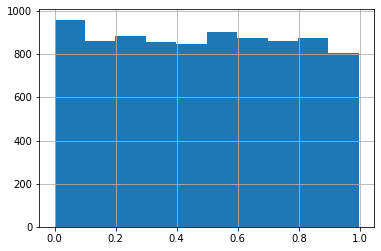

In [14]:
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")
df["pct_rank"].hist(bins=10)

In [15]:
dict_cellid_source = dict(zip(df['cell_id'].values, df['source'].values))
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
import nltk; nltk.download('wordnet')

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        #return document

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

    
def preprocess_df(df):
    """
    This function is for processing sorce of notebook
    returns preprocessed dataframe
    """
    return [preprocess_text(message) for message in df.source]

df.source = df.source.apply(preprocess_text)

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [16]:
from sklearn.model_selection import GroupShuffleSplit

NVALID = 0.1  # size of validation set

splitter = GroupShuffleSplit(n_splits=1, test_size=NVALID, random_state=0)

train_ind, val_ind = next(splitter.split(df, groups=df["ancestor_id"]))

train_df = df.loc[train_ind].reset_index(drop=True)
val_df = df.loc[val_ind].reset_index(drop=True)

In [17]:
from tqdm.notebook import tqdm

def generate_triplet(df, mode='train'):
  triplets = []
  ids = df.id.unique()
  random_drop = np.random.random(size=10000)>0.9
  count = 0

  for id, df_tmp in tqdm(df.groupby('id')):
    df_tmp_markdown = df_tmp[df_tmp['cell_type']=='markdown']

    df_tmp_code = df_tmp[df_tmp['cell_type']=='code']
    df_tmp_code_rank = df_tmp_code['rank'].values
    df_tmp_code_cell_id = df_tmp_code['cell_id'].values

    for cell_id, rank in df_tmp_markdown[['cell_id', 'rank']].values:
      labels = np.array([(r==(rank+1)) for r in df_tmp_code_rank]).astype('int')

      for cid, label in zip(df_tmp_code_cell_id, labels):
        count += 1
        if label==1:
          triplets.append( [cell_id, cid, label] )
          # triplets.append( [cid, cell_id, label] )
        elif mode == 'test':
          triplets.append( [cell_id, cid, label] )
          # triplets.append( [cid, cell_id, label] )
        elif random_drop[count%10000]:
          triplets.append( [cell_id, cid, label] )
          # triplets.append( [cid, cell_id, label] )
    
  return triplets

triplets = generate_triplet(train_df)
val_triplets = generate_triplet(val_df, mode = 'test')

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
val_df.head()

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,051d049a469e47,d7e4aeec,code,install pyspark,1,6aff1937,NaN,0.010989
1,051d049a469e47,aeb2a838,code,from pyspark import sparksession spark sparksession builder appname classification getorcreate,3,6aff1937,NaN,0.032967
2,051d049a469e47,12c1a908,code,from itertools import chain from pyspark function import count mean when create_map regexp_extract,4,6aff1937,NaN,0.043956
3,051d049a469e47,e7e68995,code,spark read input titanic train header true inferschema true spark read input titanic test header true inferschema true,6,6aff1937,NaN,0.065934
4,051d049a469e47,320bedc7,code,printschema,8,6aff1937,NaN,0.087912


In [19]:
from bisect import bisect


def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):
        j = bisect(sorted_so_far, u)
        inversions += i - j
        sorted_so_far.insert(j, u)
    return inversions


def kendall_tau(ground_truth, predictions):
    total_inversions = 0
    total_2max = 0  # twice the maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

In [20]:
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
import torch.nn.functional as F
import torch.nn as nn
import torch
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

MAX_LEN = 128

    
class MarkdownModel(nn.Module):
    def __init__(self):
        super(MarkdownModel, self).__init__()
        self.distill_bert = AutoModel.from_pretrained("../input/mymodelpairbertsmallpretrained/models/checkpoint-18000")
        self.top = nn.Linear(512, 1)

        self.dropout = nn.Dropout(0.2)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = self.dropout(x)
        x = self.top(x[:, 0, :])
        x = torch.sigmoid(x) 
        return x

In [21]:
from torch.utils.data import DataLoader, Dataset



class MarkdownDataset(Dataset):
    
    def __init__(self, df, max_len, mode='train'):
        super().__init__()
        self.df = df
        self.max_len = max_len
        self.tokenizer = AutoTokenizer.from_pretrained("../input/mymodelpairbertsmallpretrained/my_own_tokenizer", do_lower_case=True)
        self.mode=mode

    def __getitem__(self, index):
        row = self.df[index]

        label = row[-1]

        txt = dict_cellid_source[row[0]] + '[SEP]' + dict_cellid_source[row[1]]

        inputs = self.tokenizer.encode_plus(
            txt,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask, torch.FloatTensor([label])

    def __len__(self):
        return len(self.df)


In [22]:
def adjust_lr(optimizer, epoch):
    if epoch < 1:
        lr = 5e-5
    elif epoch < 2:
        lr = 1e-3
    elif epoch < 5:
        lr = 1e-4
    else:
        lr = 1e-5

    for p in optimizer.param_groups:
        p['lr'] = lr
    return lr
    
def get_optimizer(net):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=3e-4, betas=(0.9, 0.999), eps=1e-08)
    return optimizer

BS = 128
NW = 8

In [23]:
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()

def validate(model, val_loader, mode='train'):
    model.eval()
    
    tbar = tqdm(val_loader, file=sys.stdout)
    
    preds = np.zeros(len(val_loader.dataset), dtype='float32')
    labels = []
    count = 0

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            pred = model(inputs[0], inputs[1]).detach().cpu().numpy().ravel()

            preds[count:count+len(pred)] = pred
            count += len(pred)
            
            if mode=='test':
              labels.append(target.detach().cpu().numpy().ravel())
    if mode=='test':
      return preds
    else:
      return np.concatenate(labels), np.concatenate(preds)

In [24]:
paths_test = list((data_dir / 'test').glob('*.json'))
notebooks_test = [
    read_notebook(path) for path in tqdm(paths_test, desc='Test NBs')
]
test_df = (
    pd.concat(notebooks_test)
    .set_index('id', append=True)
    .swaplevel()
    .sort_index(level='id', sort_remaining=False)
).reset_index()

Test NBs:   0%|          | 0/4 [00:00<?, ?it/s]

In [25]:
test_df.source = test_df.source.apply(preprocess_text)
dict_cellid_source = dict(zip(test_df['cell_id'].values, test_df['source'].values))
test_df["rank"] = test_df.groupby(["id", "cell_type"]).cumcount()
test_df["pred"] = test_df.groupby(["id", "cell_type"])["rank"].rank(pct=False)
test_triplets = generate_triplet(test_df, mode = 'test')

  0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
test_df["pct_rank"] = 0
test_ds = MarkdownDataset(test_triplets, max_len=MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BS * 4, shuffle=False, num_workers=NW, pin_memory=False, drop_last=False)

import gc 
gc.collect()
len(test_ds), test_ds[0]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(999,
 (tensor([  101, 25169,  2951,  4094,  2951,  4162,   102, 12324, 16371,  8737,
           2100,  7399, 11208, 12324, 25462,  2951,  6364, 12324, 13523, 24759,
           4140, 29521,  1052, 22571, 10994,  2013, 15315, 19738,  6826, 22511,
          12324,  2013, 15315, 19738,  6826, 17463,  3217,  9623,  7741, 12324,
           4781,  9289,  2121,  2013, 15315, 19738,  6826, 17463,  3217,  9623,
           7741, 12324,  4094,  2013, 15315, 19738,  6826, 17727, 10421, 12324,
           3722,  5714, 18780,  2121, 12324, 16101, 18442,  5371, 18442,  3328,
          10556, 24679,  7953,  5371, 18442,  5371, 18442,  6140,  4130,  3693,
          16101, 18442,  5371, 18442,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,    

In [27]:
import sys 

model = MarkdownModel()
model = model.cuda()
model.load_state_dict(torch.load('../input/mymodelbertsmallpretrained120000/my_own_model.bin'))
y_test = validate(model, test_loader, mode='test')

Some weights of the model checkpoint at ../input/mymodelpairbertsmallpretrained/models/checkpoint-18000 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../input/mymodelpairbertsmallpretrained/models/checkpoint-180

  0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [28]:
preds_copy = y_test
pred_vals = []
count = 0
for id, df_tmp in tqdm(test_df.groupby('id')):
  df_tmp_mark = df_tmp[df_tmp['cell_type']=='markdown']
  df_tmp_code = df_tmp[df_tmp['cell_type']!='markdown']
  df_tmp_code_rank = df_tmp_code['rank'].rank().values
  N_code = len(df_tmp_code_rank)
  N_mark = len(df_tmp_mark)

  preds_tmp = preds_copy[count:count+N_mark * N_code]

  count += N_mark * N_code

  for i in range(N_mark):
    pred = preds_tmp[i*N_code:i*N_code+N_code] 

    softmax = np.exp((pred-np.mean(pred)) *20)/np.sum(np.exp((pred-np.mean(pred)) *20)) 

    rank = np.sum(softmax * df_tmp_code_rank)
    pred_vals.append(rank)

del model
del test_triplets[:]
del dict_cellid_source
gc.collect()

  0%|          | 0/4 [00:00<?, ?it/s]

59

In [29]:
test_df.loc[test_df["cell_type"] == "markdown", "pred"] = pred_vals
sub_df = test_df.sort_values("pred").groupby("id")["cell_id"].apply(lambda x: " ".join(x)).reset_index()
sub_df.rename(columns={"cell_id": "cell_order"}, inplace=True)
sub_df.to_csv("submission_2.csv", index=False)

_____

## Rank Ensemble

###### (finally)

And now for the moment we have all been waiting for: **Ensemling rank based submissions.**

But how are we going to do this?

- Let's say that we have two different submissions: "submission_1.csv", "submission_2.csv". Each containing a list of sorted strings per row.
- We would like to create a new submission such that each row contains a sorted list that is an aggregation of the sorted list in the same row of both submissions.
- To do this, we simply ensemble the indices. The index is nothing but a rank of a particular string. From the highest likelyhood of the string being in it's expected package to the lowest.
- Then sort the strings by their ensembled index.

**Reading the submissions**

In [30]:
df_1 = pd.read_csv('submission_2.csv')
df_2 = pd.read_csv('submission_1.csv')

**Averaging the indices and sorting the resulting submission by the aggregated ensembled indices**

In [31]:
new_samples = []
for sample_idx in range(len(df_1)):
    sample_1 = {k: v for v, k in enumerate(df_1.iloc[sample_idx]['cell_order'].split(' '))}
    sample_2 = {k: v for v, k in enumerate(df_2.iloc[sample_idx]['cell_order'].split(' '))}
    for key in sample_1: sample_1[key] = ( (sample_1[key] * 0.251) + (sample_2[key] * 0.749) )
    new_samples.append(' '.join([i[0] for i in list(sorted(sample_1.items(), key=lambda x:x[1]))]))
df_1['cell_order'] = new_samples

**Saving as output so we can submit**

In [32]:
df_1.to_csv('submission.csv', index = False)
df_1

,id,cell_order
0,0009d135ece78d,0a226b6a ddfd239c 8cb8d28a c6cd22db 1372ae9b e25aa9bd 90ed07ab ba55e576 f9893819 7f388a41 2843a25a 39e937ec 06dbf8cf
1,0010483c12ba9b,7f270e34 54c7cab3 fe66203e 7844d5f8 5ce8863c 4a0777c4 4703bb6d 4a32c095 865ad516 02a0be6d
2,0010a919d60e4f,23607d04 b7578789 aafc3d23 bbff12d4 80e077ec b190ebb4 584f6568 d3f5c397 8ce62db4 89b1fdd2 ed415c3c 322850af 7f53de45...
3,0028856e09c5b7,eb293dfc 012c9d02 d22526d1 3ae7ece3
